In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

In [2]:
DATASET_PATH = "dataset"   # dataset/person_name/image.jpg
IMG_SIZE = 128
BATCH_SIZE = 16
EPOCHS = 25

In [3]:
def preprocess_palm_image(img, IMG_SIZE=128, debug=False):
    # 1. Resize large images (stability)
    img = cv2.resize(img, (512, 512))

    # 2. Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # 3. Noise removal
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # 4. Otsu thresholding
    _, thresh = cv2.threshold(
        blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU
    )

    # 5. Morphological cleanup
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=2)

    # 6. Find contours (hand region)
    contours, _ = cv2.findContours(
        thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
    )

    if len(contours) == 0:
        return None

    largest = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(largest)

    # 7. Crop ROI
    roi = gray[y:y+h, x:x+w]

    # 8. CLAHE enhancement
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(roi)

    # 9. Resize & normalize
    resized = cv2.resize(enhanced, (IMG_SIZE, IMG_SIZE))
    normalized = resized / 255.0

    if debug:
        return gray, thresh, roi, enhanced, resized

    return normalized.reshape(IMG_SIZE, IMG_SIZE, 1)

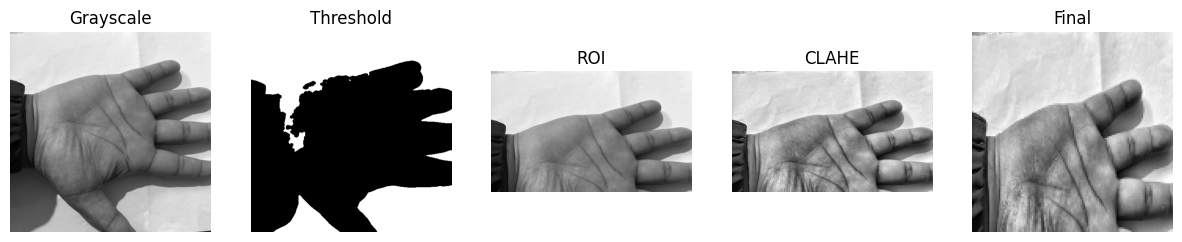

In [4]:
sample_class = os.listdir(DATASET_PATH)[0]
sample_img_path = os.path.join(DATASET_PATH, sample_class, os.listdir(os.path.join(DATASET_PATH, sample_class))[0])
img = cv2.imread(sample_img_path)

gray, thresh, roi, enhanced, resized = preprocess_palm_image(img, debug=True)

titles = ["Grayscale", "Threshold", "ROI", "CLAHE", "Final"]
images = [gray, thresh, roi, enhanced, resized]

plt.figure(figsize=(15,3))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(images[i], cmap="gray")
    plt.title(titles[i])
    plt.axis("off")
plt.show()

In [5]:
images = []
labels = []

class_names = sorted(os.listdir(DATASET_PATH))

for idx, person in enumerate(class_names):
    person_path = os.path.join(DATASET_PATH, person)

    for img_name in os.listdir(person_path):
        img_path = os.path.join(person_path, img_name)
        img = cv2.imread(img_path)

        processed = preprocess_palm_image(img, IMG_SIZE)
        if processed is None:
            continue

        images.append(processed)
        labels.append(idx)

images = np.array(images)
labels = to_categorical(labels, num_classes=len(class_names))

print("Images shape:", images.shape)
print("Labels shape:", labels.shape)

Images shape: (320, 128, 128, 1)
Labels shape: (320, 4)


In [6]:
X_train, X_val, y_train, y_val = train_test_split(
    images, labels, test_size=0.2, random_state=42, stratify=labels
)

In [7]:
datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.05,
    height_shift_range=0.05
)

datagen.fit(X_train)

In [8]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)),
    BatchNormalization(),
    MaxPooling2D(),

    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(),

    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(len(class_names), activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

c:\Users\sudip\OneDrive\Desktop\palm-recognition-csy2082\env\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,517,380 (24.86 MB)

 Trainable params: 6,516,932 (24.86 MB)

 Non-trainable params: 448 (1.75 KB)

In [9]:
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
    validation_data=(X_val, y_val),
    epochs=EPOCHS
)

Epoch 1/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.7422 - loss: 1.0060 - val_accuracy: 0.5000 - val_loss: 1.3350
Epoch 2/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 19s 966ms/step - accuracy: 0.9023 - loss: 0.3323 - val_accuracy: 0.2500 - val_loss: 1.5777
Epoch 3/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.9727 - loss: 0.1427 - val_accuracy: 0.2500 - val_loss: 1.6724
Epoch 4/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.9648 - loss: 0.1516 - val_accuracy: 0.3750 - val_loss: 2.0540
Epoch 5/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 16s 989ms/step - accuracy: 0.9805 - loss: 0.0721 - val_accuracy: 0.5000 - val_loss: 2.4327
Epoch 6/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 16s 985ms/step - accuracy: 0.9961 - loss: 0.0221 - val_accuracy: 0.4844 - val_loss: 2.5315
Epoch 7/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.9922 - loss: 0.0220 - val_accuracy: 0.5000 - val_loss: 2.7569
Epoch 8/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.9805 - loss: 0.0555 - val_accuracy: 0.2500 - 

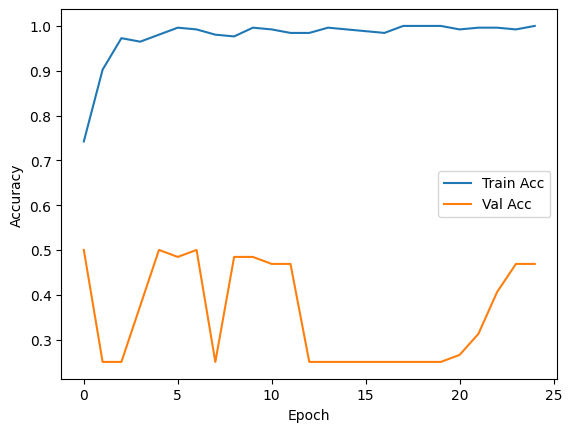

In [10]:
plt.plot(history.history['accuracy'], label="Train Acc")
plt.plot(history.history['val_accuracy'], label="Val Acc")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

In [11]:
from tensorflow.keras.models import Model

embedding_model = Model(
    inputs=model.layers[0].input,  # Get input directly from the first layer
    outputs=model.layers[-2].output  # Dense(128)
)

In [12]:
import pickle

reference_embeddings = {}
EMBEDDING_THRESHOLD = 1.2

for person in class_names:
    embeddings = []
    person_path = os.path.join(DATASET_PATH, person)

    for img_name in os.listdir(person_path):
        img_path = os.path.join(person_path, img_name)

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = img / 255.0
        img = img.reshape(1, IMG_SIZE, IMG_SIZE, 1)

        emb = embedding_model.predict(img)[0]
        embeddings.append(emb)

    reference_embeddings[person] = np.mean(embeddings, axis=0)

with open("reference_embeddings.pkl", "wb") as f:
    pickle.dump(reference_embeddings, f)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72

In [13]:
# Save Model
model.save("palm_recognition_model.h5")